In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc_bart as pmb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
RANDOM_SEED = 4579
np.random.seed(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [3]:
from scipy import stats

stats.norm(1, 0.005).ppf(0.95)

1.0082242681347573

In [4]:
funcs = [
    lambda x: 10 * x,
    lambda x: 10 * np.sin(x * 2 * np.pi),
    lambda x: 2 - 4 * np.where(x < 0.5, 1, 0),
]

In [5]:
X_lin = np.linspace(0, 1, 200)
Y_lin = np.random.normal(funcs[0](X_lin), 2, size=200)
X_lin = X_lin[:, None]

X_sin = np.linspace(0, 1, 200)
Y_sin = np.random.normal(funcs[1](X_sin), 2, size=200)
X_sin = X_sin[:, None]

X_stp = np.linspace(0, 1, 200)
Y_stp = np.random.normal(funcs[2](X_stp), 0.2, size=200)

X_stp = X_stp[:, None]


XS = [X_lin, X_sin, X_stp]
YS = [Y_lin, Y_sin, Y_stp]

In [6]:
idatas = []
m_trees = []
for X, Y in zip(XS, YS):
    for m in [10, 50, 200]:
        with pm.Model() as functions:
            σ = pm.HalfNormal("σ", Y.std())
            μ = pmb.BART("μ", X, Y, m=m)
            y = pm.Normal("y", μ, σ, observed=Y)
            idata = pm.sample(random_seed=RANDOM_SEED,
                              compute_convergence_checks=False,
                              idata_kwargs={"log_likelihood": True})
            idatas.append(idata)
            m_trees.append(μ.owner.op.m)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 149 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 136 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 146 seconds.


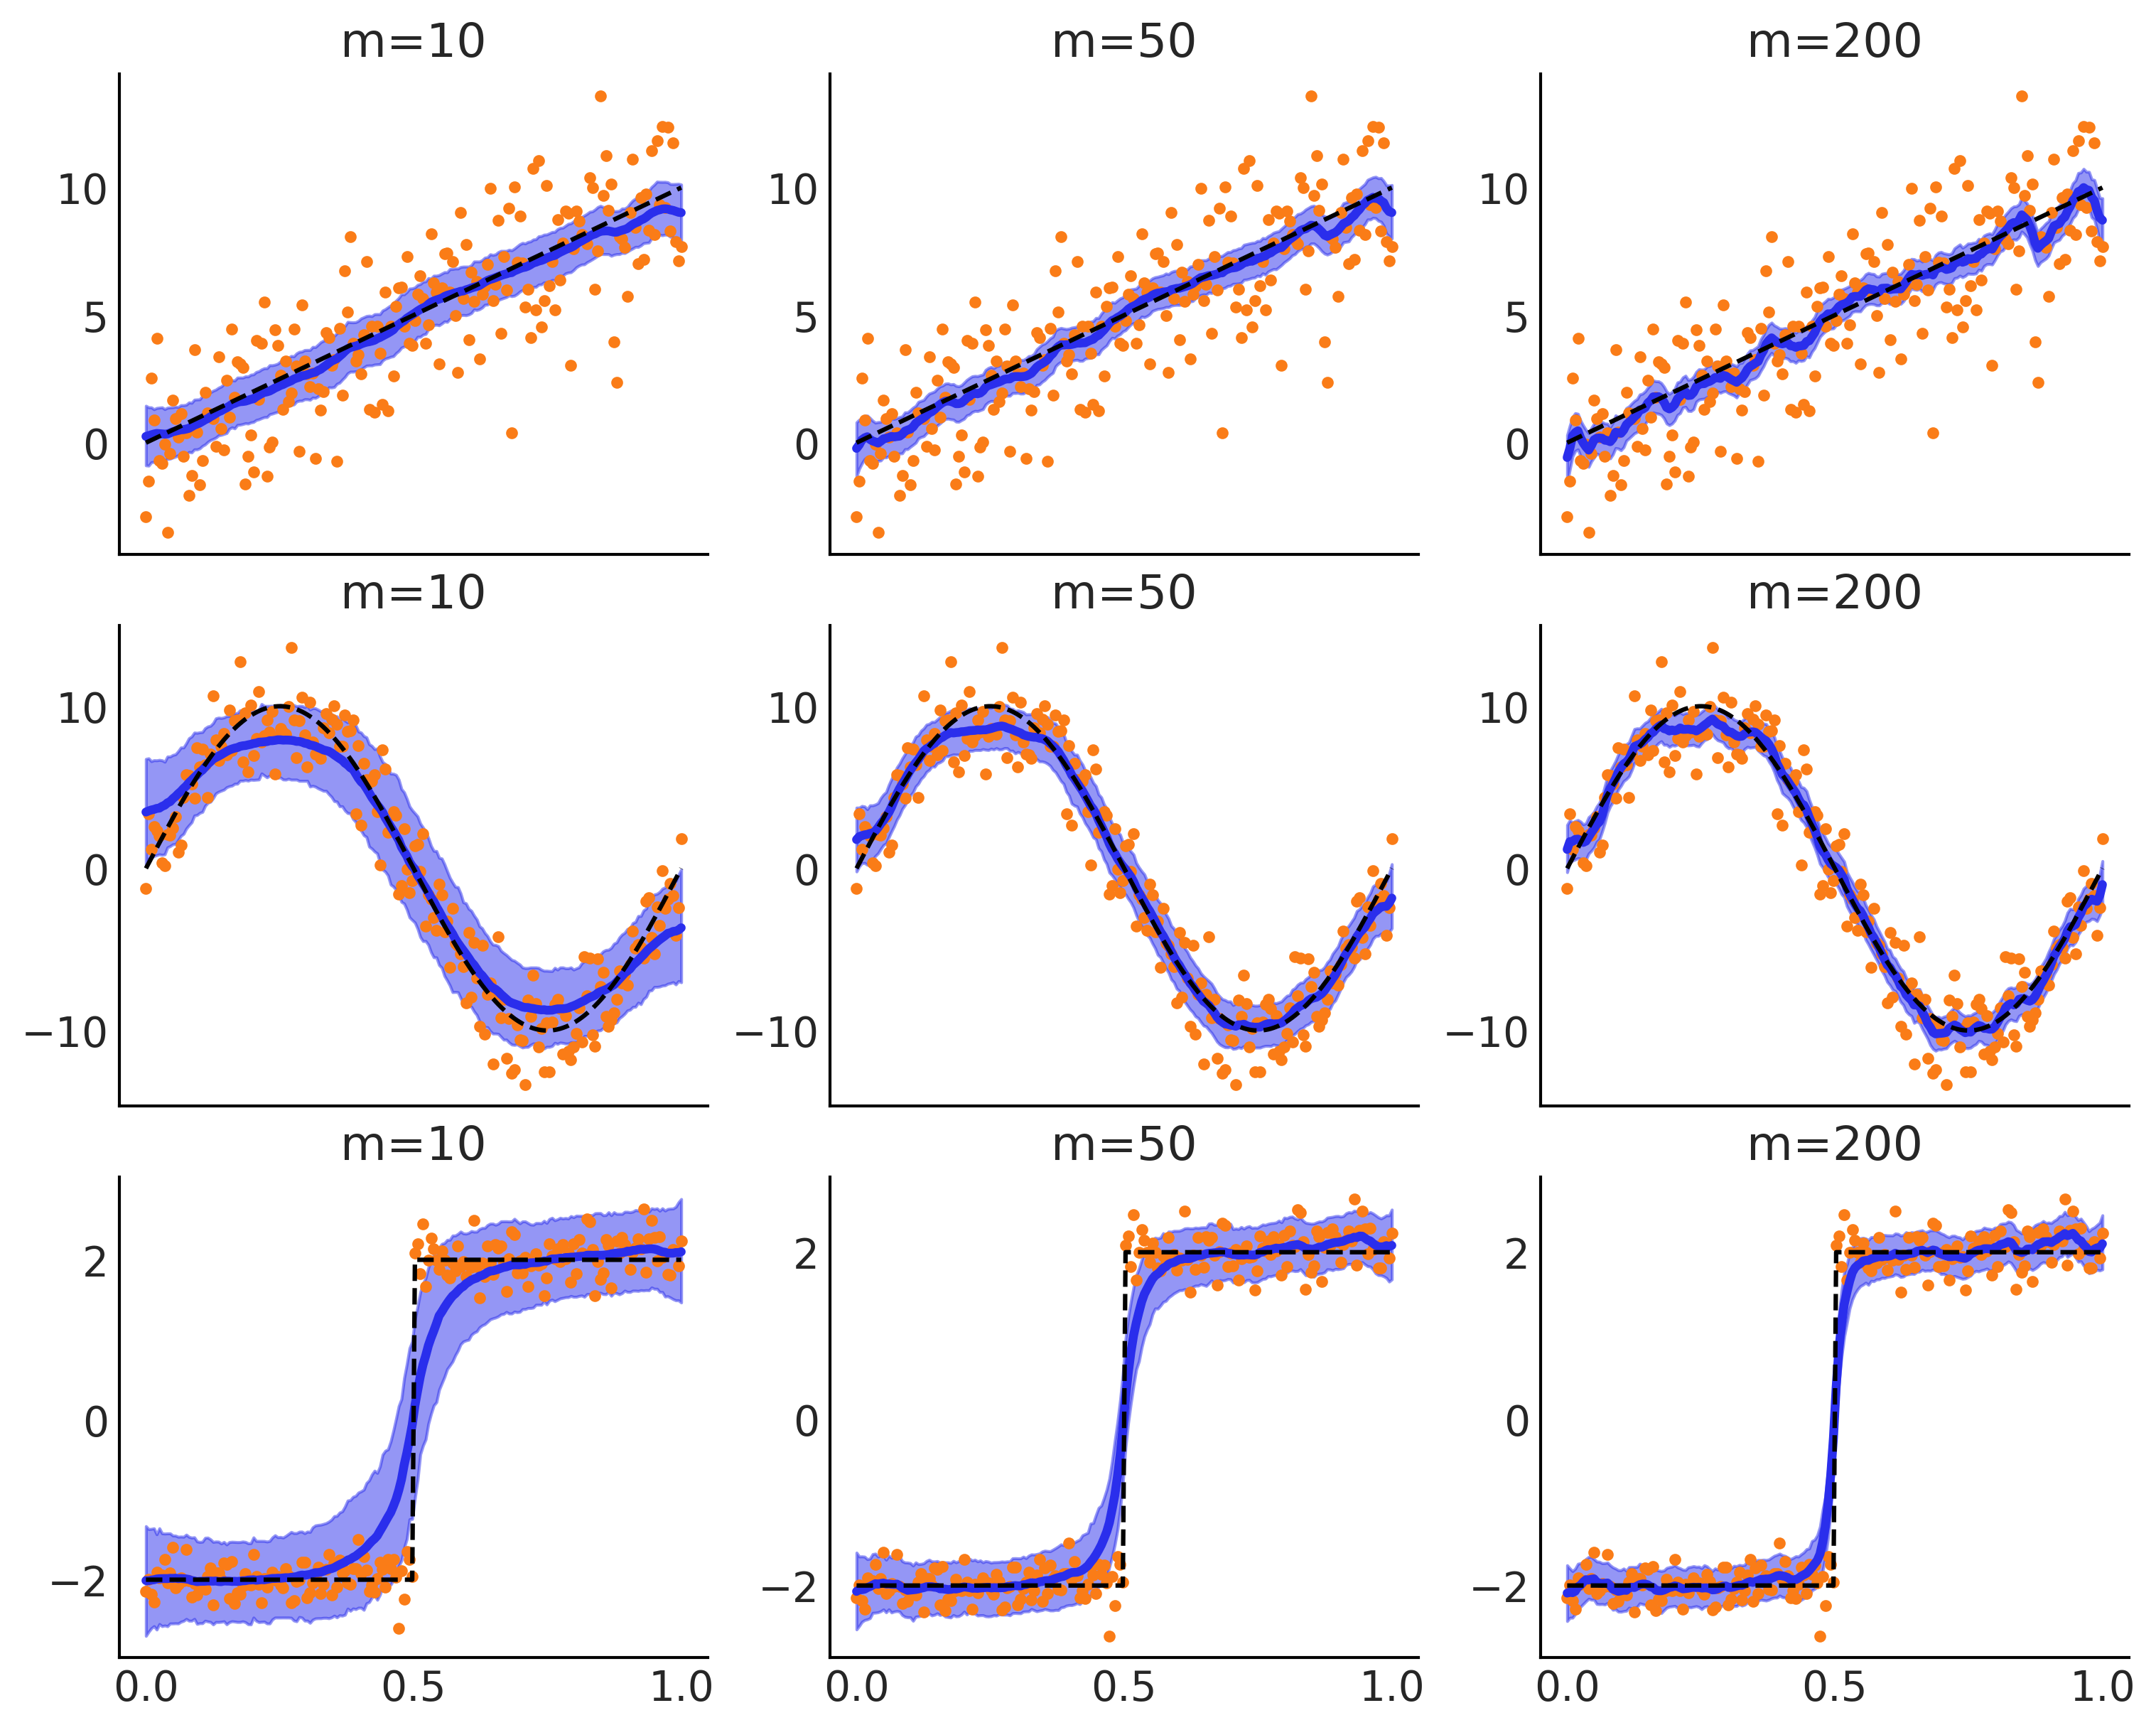

In [7]:
_, axes = plt.subplots(3, 3, figsize=(10, 8), sharex=True)


for idata, m, ax, X, Y, f in zip(
    idatas,
    m_trees,
    np.ravel(axes),
    np.repeat(XS, 3, 0),
    np.repeat(YS, 3, 0),
    np.repeat(funcs, 3),
):
    mean = idata.posterior["μ"].mean(dim=["draw", "chain"])
    ax.plot(X[:, 0], mean, lw=3)
    az.plot_hdi(X[:, 0], idata.posterior["μ"], color="C0", smooth=False, ax=ax)
    ax.plot(X[:, 0], Y, ".", zorder=1)
    ax.plot(X[:, 0], f(X), "k--")
    ax.set_title(f"{m=}")
    plt.savefig("simple_function.png")

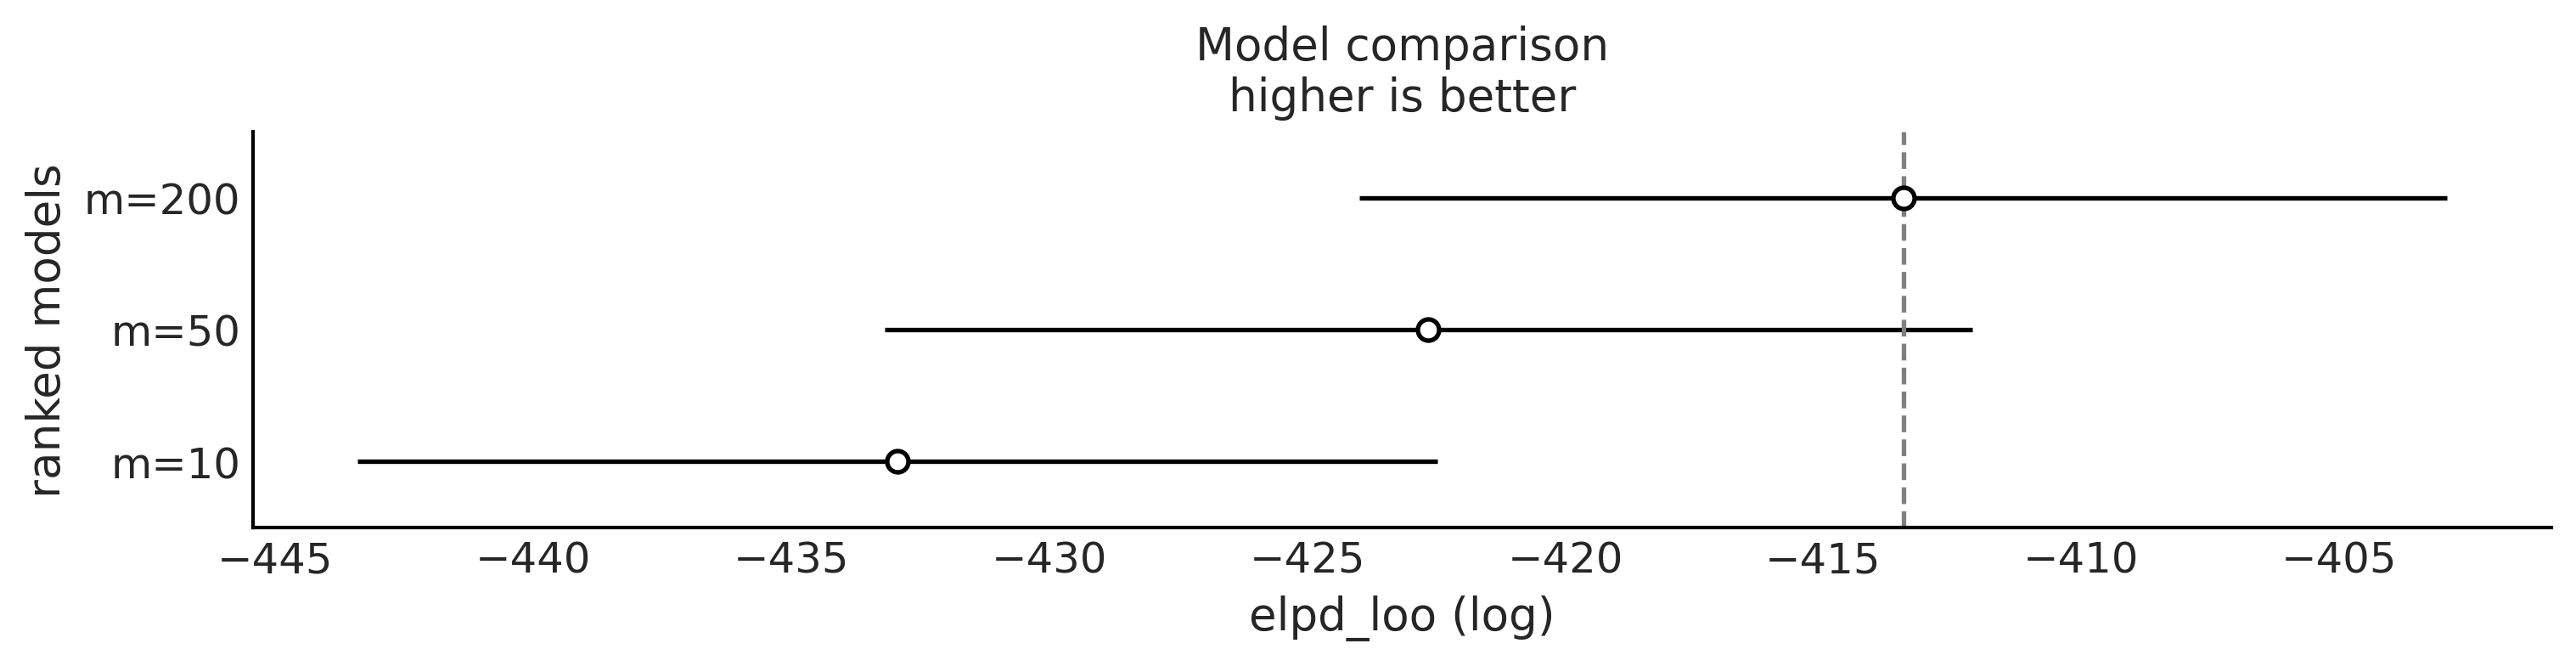

In [8]:
cmp = az.compare(dict(zip(["m=10", "m=50", "m=200"], idatas[:3])))
ax = az.plot_compare(
    cmp, plot_ic_diff=False, insample_dev=False, figsize=(10, 2.5), legend=False
)
plt.savefig("LOO_lin.png")

/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


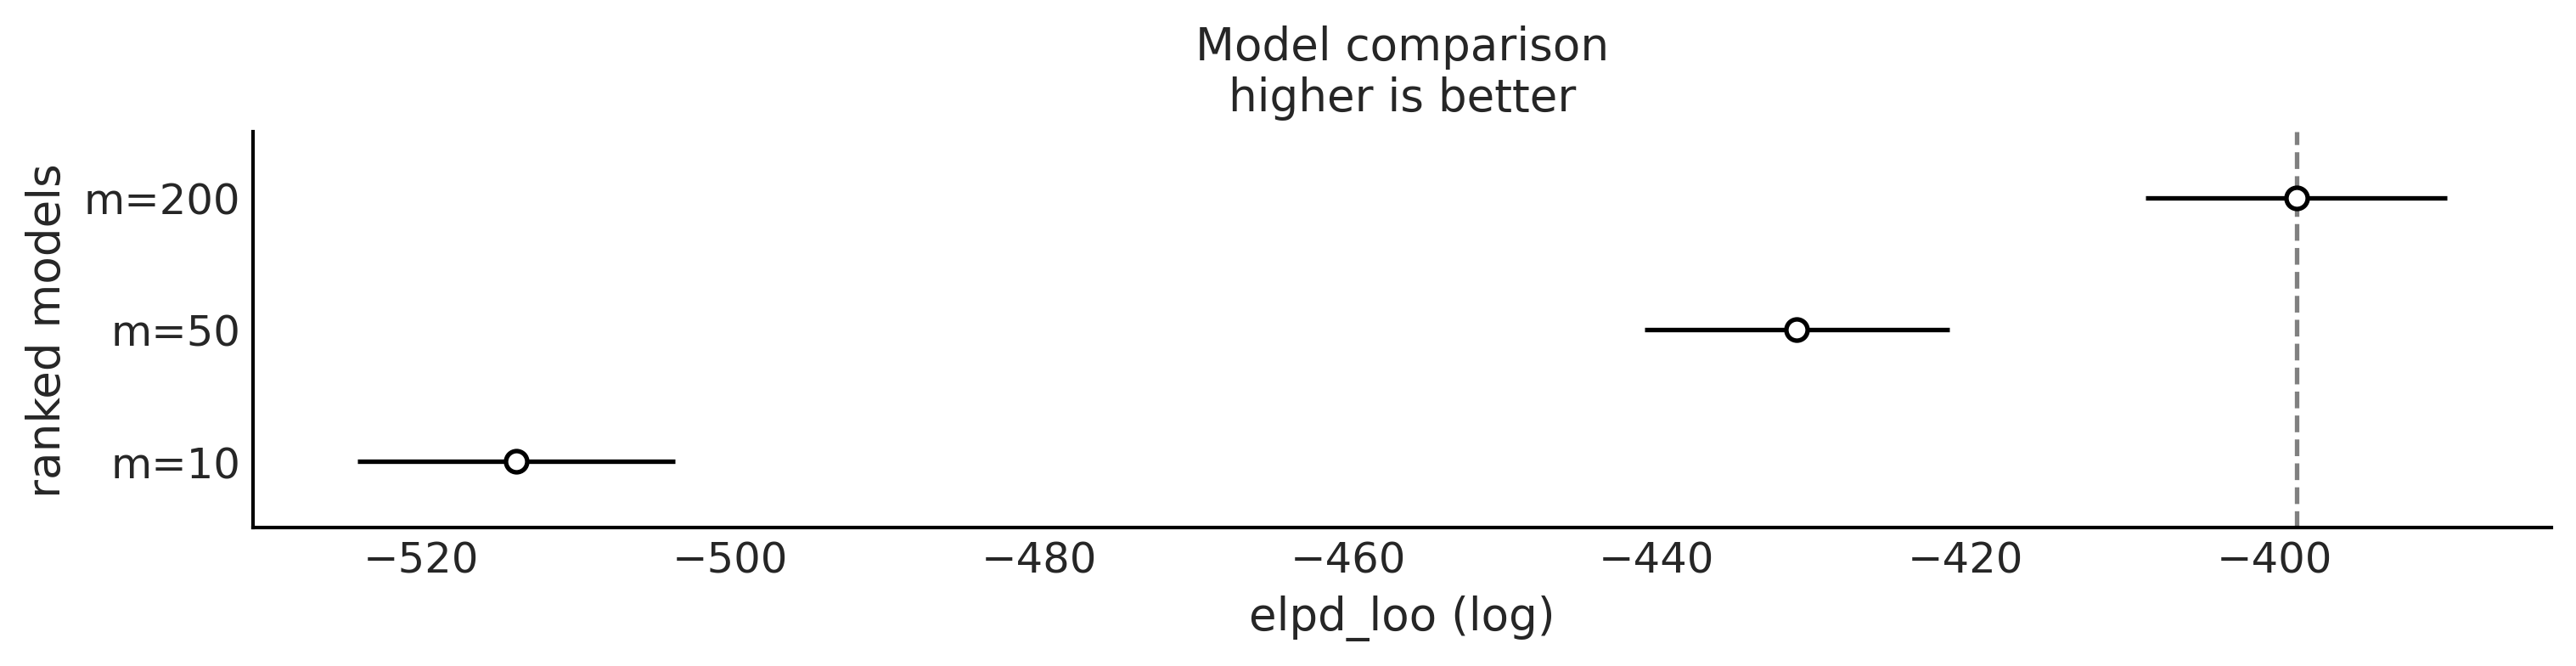

In [9]:
cmp = az.compare(dict(zip(["m=10", "m=50", "m=200"], idatas[3:6])))
ax = az.plot_compare(
    cmp, plot_ic_diff=False, insample_dev=False, figsize=(10, 2.5), legend=False
)
plt.savefig("LOO_sin.png")

/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape p

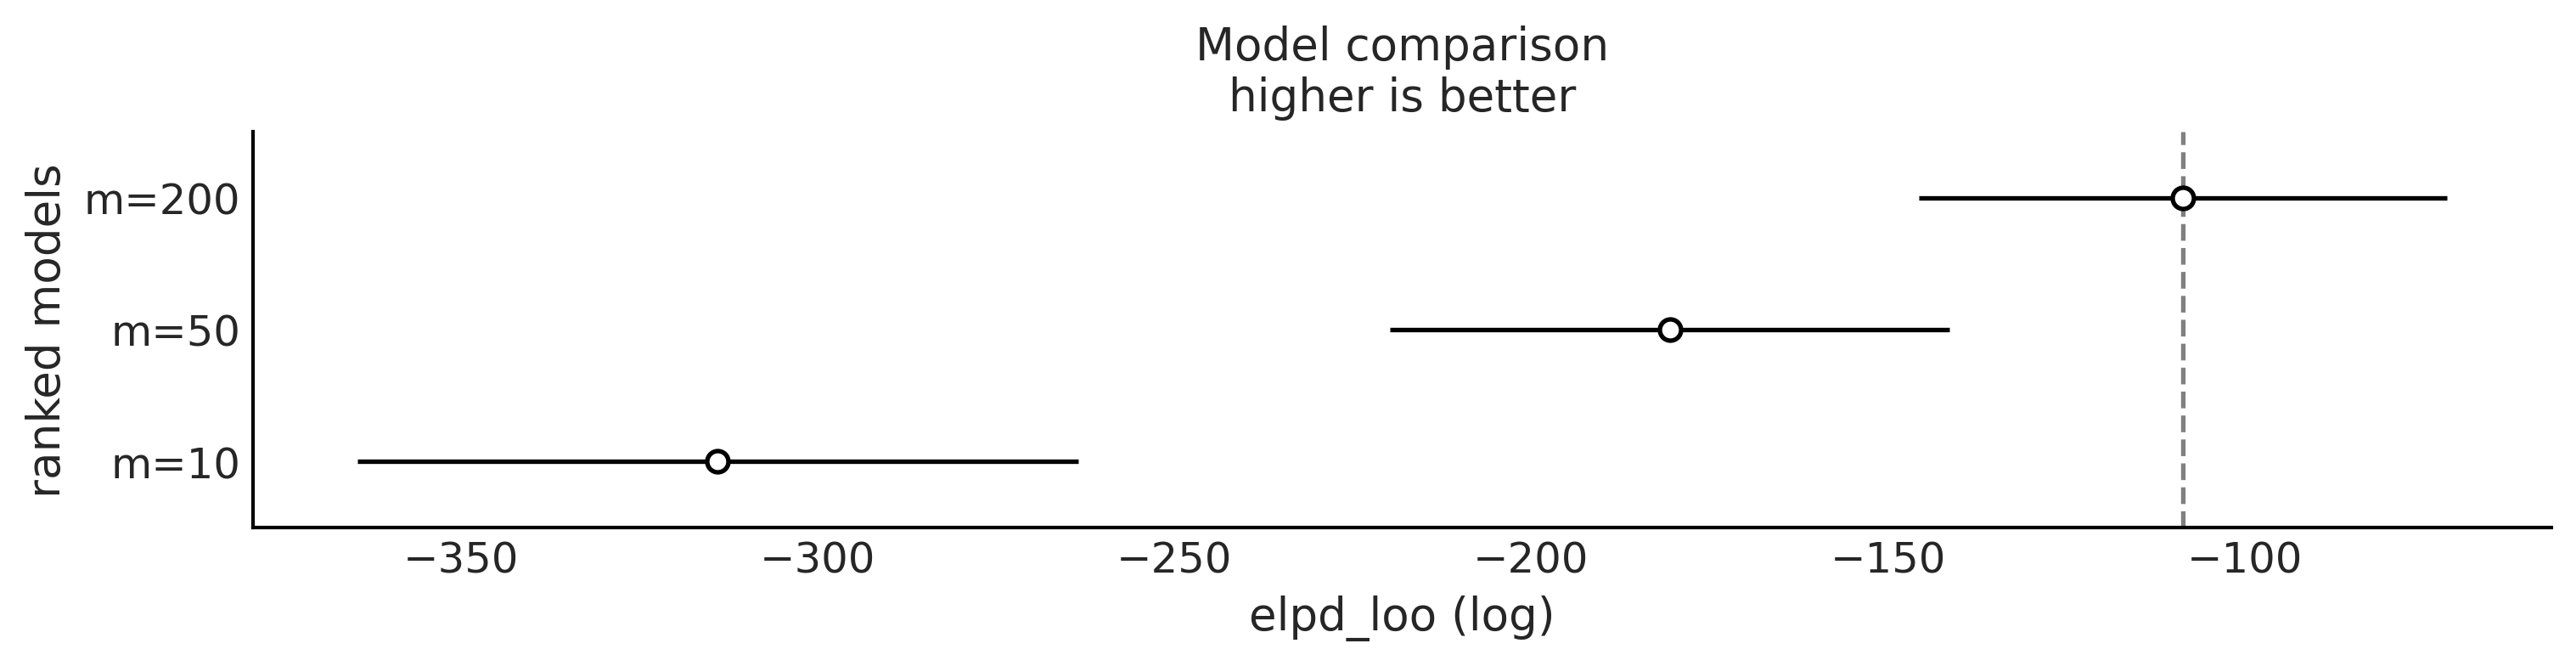

In [10]:
cmp = az.compare(dict(zip(["m=10", "m=50", "m=200"], idatas[6:])))
ax = az.plot_compare(
    cmp, plot_ic_diff=False, insample_dev=False, figsize=(10, 2.5), legend=False
)
plt.savefig("LOO_stp.png")